# Visualizing Maximum Activation Images
### from keras blog (https://blog.keras.io/category/demo.html)

Previously, we pass in a real image and visualize its activation maps from different network layers. In this tutorial we introduce a generative approach to visualize what each layer learns by constructing an image that maximizes the activation response of a particular neuron in a layer.

If you are already familar with gradient ascent and maxumum activation images, jump to the <a href="#exp"> "Encapsulate computations" </a> section to try out the experiments/examples. 

## Gradient ascent & activation maximization 

The goal of gradient ascent is to genearte a synthetic image that maximally activates a neuron.  

Essentially we are pursuing the following

$$ arg\, max\, S_c(I)\; -\; \lambda\,||I||_2^2 $$ 

where $I$ is the input image pixels and $S_c(I)$ is the targeted neuron activation by a feed-forward.   

The algorithm is :
1. generate a random or blank image as initial input.
2. feed-forward image to compute current objective/loss
3. back-propagate to get gradient of the neuron value with respect to input image pixels
4. make a small update on the input image.
5. repeat step 2 to 4 until convergence. 

for more details refer to CS231 Lecture 12 Visualization and Understanding http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture12.pdf

*** Now you are ready to implement gradient ascent and activation maximization ***

In [8]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline 

from keras.applications import VGG16
from keras.applications import VGG16unnormalized

*** Attention: *** make sure to put the vgg16unnormalized.py file inside your keras.applications library, and then add a line of "from .vgg16unnormalized import VGG16unnormalized" to the __init__.py file in the same directory. We will need the VGG16unnormalized model for making better maximum activation images. 

## Instantiate VGG16 model（without FCs）

In [13]:
model = VGG16(include_top=False, weights='imagenet')

# create a python dictionary, (key: layer name, value: layer object)  
layer_dict = dict([(layer.name, layer) for layer in model.layers])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

Note that we only go up to the last convolutional layer --we don't include fully-connected layers. The reason is that adding the fully connected layers forces you to use a fixed input size for the model (224x224, the original ImageNet format). By only keeping the convolutional modules, our model can be adapted to arbitrary input sizes.

## Constructing maximum activation image(s)

Define task (generate image to maximize activation) related attributes.

In [14]:
img_width = 128
img_height = 128

layer_name = 'block5_conv1'
filter_index = 0  # must be an valid integer as specified by the corresponding layer filters 

Define a loss function that will seek to maximize the activation of a specific filter (filter_index) in a specific layer (layer_name). We do this via a Keras backend function, which allows our code to run both on top of TensorFlow and Theano.

In [16]:
from keras import backend as K

input_img = model.input

# build a loss function that maximizes the activation of the nth filter of the layer considered
layer_output = layer_dict[layer_name].output

if K.image_data_format() == 'channels_first':
    loss = K.mean(layer_output[:, filter_index, :, :])
else:
    loss = K.mean(layer_output[:, :, :, filter_index])

Do gradient descent on the specified loss with respect to the input pixels. 

*** Trick: *** normalize the gradient of the pixels of the input image, which avoids very small and very large gradients and ensures a smooth gradient ascent process.

In [17]:
# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

# normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

Use Keras backend to define a fucntion that compiles the loss and gradients operations given network inputs.

In [18]:
# this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])

Generate random image to apply gradients on.

In [19]:
import numpy as np

# we start from a gray image with some random noise
if K.image_data_format() == 'channels_first':
    input_img_data = np.random.random((1, 3, img_width, img_height))
else:
    input_img_data = np.random.random((1, img_width, img_height, 3))
    
input_img_data = (input_img_data - 0.5) * 20 + 128

*** Compute: *** do gradient ascent to get maximum activation images

In [20]:
# run gradient ascent for 50 steps
step = 1

for i in range(50):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

Process and display generated images 

In [10]:
from scipy.misc import imsave

# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5    # center to 0.5 for the [0, 1] interval
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

### Visualize maximum activation from an hidden layer neuron

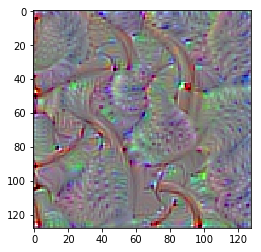

In [21]:
img = input_img_data[0]
img = deprocess_image(img)
imsave('%s_filter_%d.png' % (layer_name, filter_index), img)
plt.imshow(img)    

<p id="exp"></p>
## Encapsulate computations

We aim to visualize and compare different filters, but we don't want to go through the same computational process for each single filter. Here is when encapsulation comes into play, programmers are lazy so we like to automate our calculations in functions and hopefully be able to reuse them in the future.   

The following functions define a complete API to easily generate maximum activation images given a model, layer name, filter index and other necessary parameters (dimensions & hyperparameters). 

In [24]:
import numpy as np
import tensorflow as tf
from keras import backend as K
from scipy.misc import imsave

def construct_layer_dict(model):
    """ construct a dictionary of model layers indexed by names 
    """
    return dict([(layer.name, layer) for layer in model.layers])

def get_max_response_image_raw(model, layer_dict, layer_name, filter_index, img_width, img_height, 
                               step, iteration, base_img=None, initializatoin='random', verbose=True):
    """ generate image that maximizes activation of a layer filter with one step 
    
    Args:
        model: CNN model.
        layer_dict: layer dictionary for the model.
        layer_name: name of the layer to visualize.
        filter_index: index of the filter within the specified layer to visualize.
        img_width: width of the image to generate.
        img_height: height of the image to generate.
        step: gradient ascent update step.
        iteration: number of iteration to do gradient ascent.
        base_img: image to do gradient ascent on, randomly initialized if none is provided.
        initialization: only when base_img is None, specifies random initialization or zero initialization. 
        verbose: whether or not to print out training status messages.
    
    Returns:
        input_img_data: generated maximum activation image.
    """
    input_img = model.input
    layer_output = layer_dict[layer_name].output
    
    if K.image_data_format() == 'channels_first':
        if len(layer_output.shape) == 4:    # a convolutional layer
            loss = K.mean(layer_output[:, filter_index, :, :])
        else:    # a fully connected layer
            loss = K.mean(layer_output[:, filter_index])
            
        if base_img == None:
            if initializatoin == 'random':
                input_img_data = np.random.random((1, 3, img_width, img_height))
            elif initializatoin == 'blank':
                input_img_data = np.zeros((1, 3, img_width, img_height))
        else:
            input_img_data = base_img 
    else:
        if len(layer_output.shape) == 4:
            loss = K.mean(layer_output[:, :, :, filter_index])
        else:
            loss = K.mean(layer_output[:, filter_index])
            
        if base_img == None:
            if initializatoin == 'random':
                input_img_data = np.random.random((1, img_width, img_height, 3))
            elif initializatoin == 'blank':
                input_img_data = np.zeros((1, 3, img_width, img_height))
        else:
            input_img_data = base_img 
        
    grads = K.gradients(loss, input_img)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([input_img], [loss, grads])
    input_img_data = (input_img_data - 0.5) * 20 + 128
    
    for i in range(iteration):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
        if i%100 == 0 and verbose:
            print("iter: %d, loss: %g" % (i, loss_value))
    
    return input_img_data

def get_max_response_image_processed(raw_img, img_index):
    """ processs the raw generated maximum activation image for better visualization.
    
    Args:
        raw_img: raw generated image batch.
        img_index: index of the image instance.
        
    Returns:
        processed image.
    """
    img = raw_img[img_index]
    return deprocess_image(img)

def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5    # center to 0.5 for the [0, 1] interval
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def save_image(img_path, img):
    """ save the image to the given path.
    """
    imsave(img_path, img)

## Visualization

Now we can make use of the above API functions to generate visualizations.   

Specifically, we will try to visualize maximum activations from the output layer, which has been chopped off the softmax layer by using the modified VGG16unnormalized model. 

In [4]:
#
from keras.applications import VGG16unnormalized

# new_model = VGG16(weights='imagenet')
new_model= VGG16unnormalized(weights='imagenet')

new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [5]:
new_layer_dict = construct_layer_dict(new_model)
new_layer_dict

{'block1_conv1': <keras.layers.convolutional.Conv2D at 0x104fd17b8>,
 'block1_conv2': <keras.layers.convolutional.Conv2D at 0x1046b2da0>,
 'block1_pool': <keras.layers.pooling.MaxPooling2D at 0x114678fd0>,
 'block2_conv1': <keras.layers.convolutional.Conv2D at 0x11468a4a8>,
 'block2_conv2': <keras.layers.convolutional.Conv2D at 0x114682c88>,
 'block2_pool': <keras.layers.pooling.MaxPooling2D at 0x1146c3ac8>,
 'block3_conv1': <keras.layers.convolutional.Conv2D at 0x1146cc9b0>,
 'block3_conv2': <keras.layers.convolutional.Conv2D at 0x114910e10>,
 'block3_conv3': <keras.layers.convolutional.Conv2D at 0x11492d358>,
 'block3_pool': <keras.layers.pooling.MaxPooling2D at 0x114966a58>,
 'block4_conv1': <keras.layers.convolutional.Conv2D at 0x114980240>,
 'block4_conv2': <keras.layers.convolutional.Conv2D at 0x114979ac8>,
 'block4_conv3': <keras.layers.convolutional.Conv2D at 0x11499eb38>,
 'block4_pool': <keras.layers.pooling.MaxPooling2D at 0x1149d5cc0>,
 'block5_conv1': <keras.layers.convolu

### Define layer and neuron to investigate

In [6]:
new_layer_name = "predictions"
new_filter_index = 10
new_image_width = 224
new_image_height = 224
new_step = 1
new_iteration = 1000
# experimentally decent result happens at least after 200+ iterations 

### First 1000 passes

In [9]:
new_max_image = get_max_response_image_raw(new_model, new_layer_dict, new_layer_name, new_filter_index,
                                           new_image_width, new_image_height, new_step, new_iteration)

iter: 0, loss: 1.26727
iter: 100, loss: 472.271
iter: 200, loss: 1222.74
iter: 300, loss: 2219.53
iter: 400, loss: 3473.16
iter: 500, loss: 4888.35
iter: 600, loss: 6468
iter: 700, loss: 8233.06
iter: 800, loss: 10113.4
iter: 900, loss: 12135.3


In [12]:
new_max_image_processed = get_max_response_image_processed(new_max_image, 0)

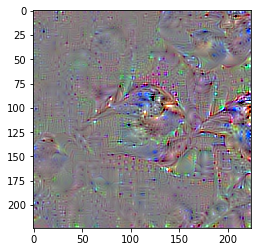

In [13]:
plt.imshow(new_max_image_processed)

### Second 1000 passes (total 2000)  

*** Note: *** With more passes, the generated image should demonstrate a richer set of features/patterns for the related class. 

In [14]:
new_max_image2 = get_max_response_image_raw(new_model, new_layer_dict, new_layer_name, new_filter_index,
                                           new_image_width, new_image_height, new_step, new_iteration, new_max_image)

/Users/zhaocongyuan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:47: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


iter: 0, loss: 5.55549
iter: 100, loss: 802.084
iter: 200, loss: 1986.89
iter: 300, loss: 3584.69
iter: 400, loss: 5487.23
iter: 500, loss: 7589.23
iter: 600, loss: 9786.35
iter: 700, loss: 12046.1
iter: 800, loss: 14371.3
iter: 900, loss: 16730.7


In [15]:
new_max_image_processed2 = get_max_response_image_processed(new_max_image2, 0)

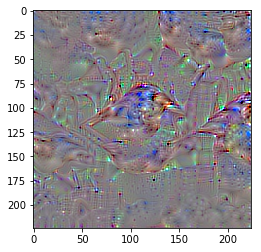

In [16]:
plt.imshow(new_max_image_processed2)

### Third 1000 passes (total 3000)  

*** Note ***: Most images shoud have already converged at this time, so the generated images will look quite the same as the 2000 passes ones.

In [17]:
new_max_image3 = get_max_response_image_raw(new_model, new_layer_dict, new_layer_name, new_filter_index,
                                           new_image_width, new_image_height, new_step, new_iteration, new_max_image2)

/Users/zhaocongyuan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:47: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


iter: 0, loss: 7.68177
iter: 100, loss: 980.173
iter: 200, loss: 2382.63
iter: 300, loss: 4259.71
iter: 400, loss: 6396.81
iter: 500, loss: 8683.07
iter: 600, loss: 11070
iter: 700, loss: 13528.3
iter: 800, loss: 16010.4
iter: 900, loss: 18514.9


In [18]:
new_max_image_processed3 = get_max_response_image_processed(new_max_image3, 0)

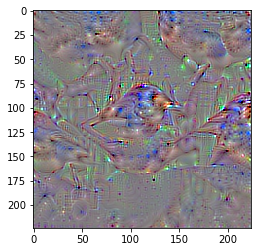

In [19]:
plt.imshow(new_max_image_processed3)

### More passes, have fun ...   

If your generated image is still not clear or if you just want to try out more passes, you are welcome to do so!  
*** Note: *** Just remember to save your final generated image to demonstrate your work (important).  

In [20]:
# save the final maximum activation image for the current class.
save_image("10-2500.png", new_max_image_processed)

### Visualize more filters and classes !

By visualizing filters from the output layer which gives the final classification results, we can have a sense of how the network understands or recognizes different image classes to be categorized.

iter: 0, loss: -2.36601
iter: 100, loss: 681.691
iter: 200, loss: 1666.23
iter: 300, loss: 3010.02
iter: 400, loss: 4584.65
iter: 500, loss: 6308.13
iter: 600, loss: 8166.61
iter: 700, loss: 10073.8
iter: 800, loss: 12028.3
iter: 900, loss: 13998.4
iter: 0, loss: -0.52424
iter: 100, loss: 725.258
iter: 200, loss: 1758.29
iter: 300, loss: 3134.82
iter: 400, loss: 4752.65
iter: 500, loss: 6578.61
iter: 600, loss: 8520.14
iter: 700, loss: 10504.9
iter: 800, loss: 12555.9
iter: 900, loss: 14636.9
iter: 0, loss: -0.451674
iter: 100, loss: 522.236
iter: 200, loss: 1315.58
iter: 300, loss: 2427.05
iter: 400, loss: 3773.03
iter: 500, loss: 5291.45
iter: 600, loss: 6916.91
iter: 700, loss: 8624.51
iter: 800, loss: 10374.9
iter: 900, loss: 12158.8
iter: 0, loss: -0.208385
iter: 100, loss: 643.362
iter: 200, loss: 1603.18
iter: 300, loss: 2906.81
iter: 400, loss: 4462.94
iter: 500, loss: 6234.14
iter: 600, loss: 8139.77
iter: 700, loss: 10107.9
iter: 800, loss: 12135.7
iter: 900, loss: 14212.1
it

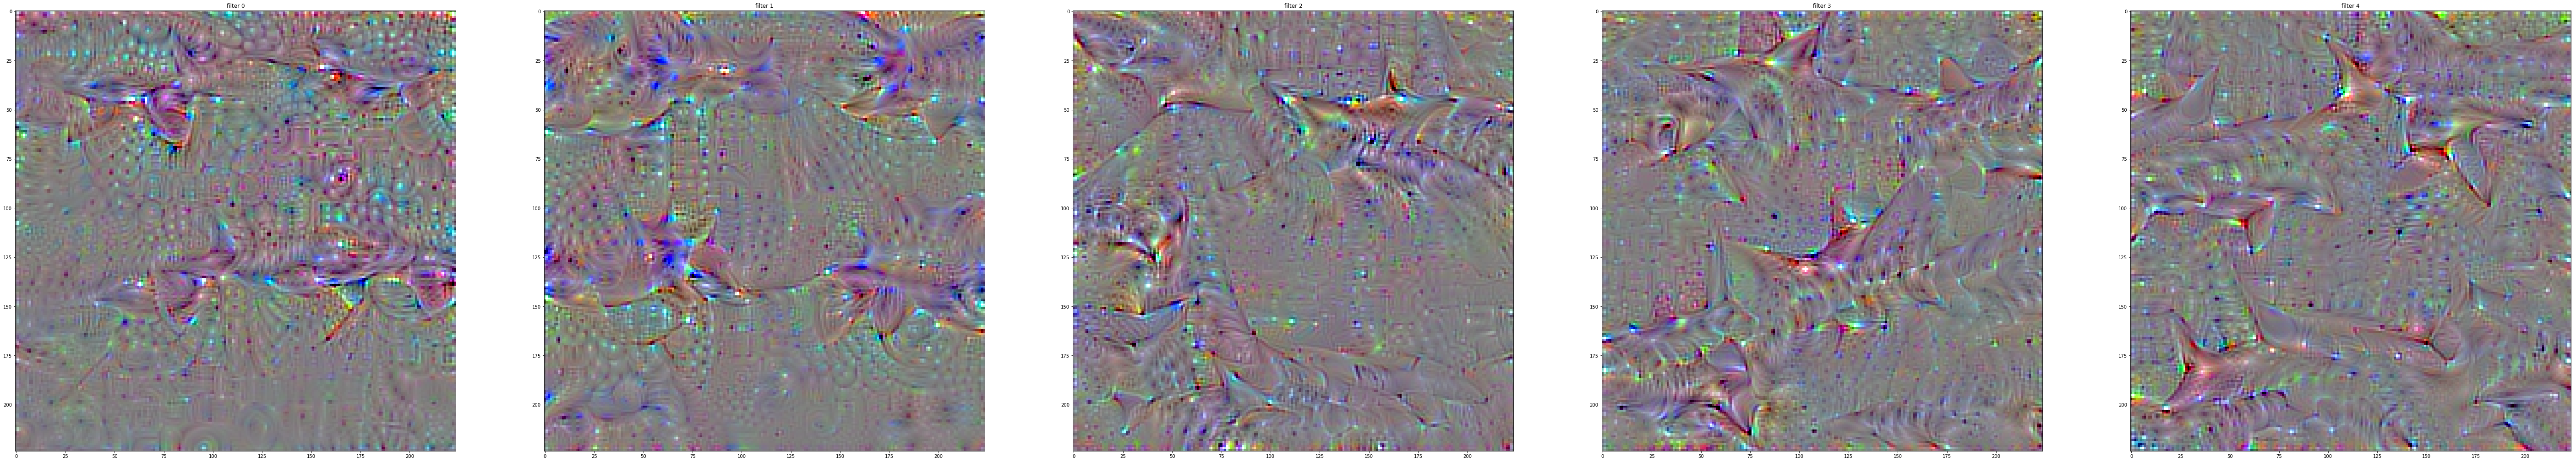

In [21]:
fig = plt.figure(figsize=(100, 50))
num = 5

for i in range(num):
    plt.subplot(int(num/5)+1, 5, i+1)
    max_image = get_max_response_image_raw(new_model, new_layer_dict, new_layer_name, i,
                                           new_image_width, new_image_height, new_step, new_iteration)
    max_image_processed = get_max_response_image_processed(max_image, 0)
    plt.imshow(max_image_processed)
    plt.title("filter %d" % i)
    
plt.show()

In [23]:
fig.savefig("first5classes.jpg")